#Model Training

## Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os
from sklearn.preprocessing import StandardScaler
from tensorflow import one_hot
from tensorflow.keras import datasets, layers, models, optimizers, callbacks, utils, Input, Model
from sklearn.metrics import accuracy_score, RocCurveDisplay, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer, StandardScaler

In [ ]:
#import and extract zip file
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/satellite_data/EuroSAT_RGB.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
#assemble data
train, test = utils.image_dataset_from_directory(directory = '/tmp/EuroSAT_RGB',
                                                  image_size=(64, 64),
                                                  validation_split = 0.2,
                                                  subset="both",
                                                  seed = 222,
                                                  batch_size = 32,
                                                  shuffle = True
                                                  )

Found 27000 files belonging to 10 classes.
Using 21600 files for training.
Using 5400 files for validation.


In [ ]:
#pull list of inferred class names
class_names = train.class_names
print(class_names)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


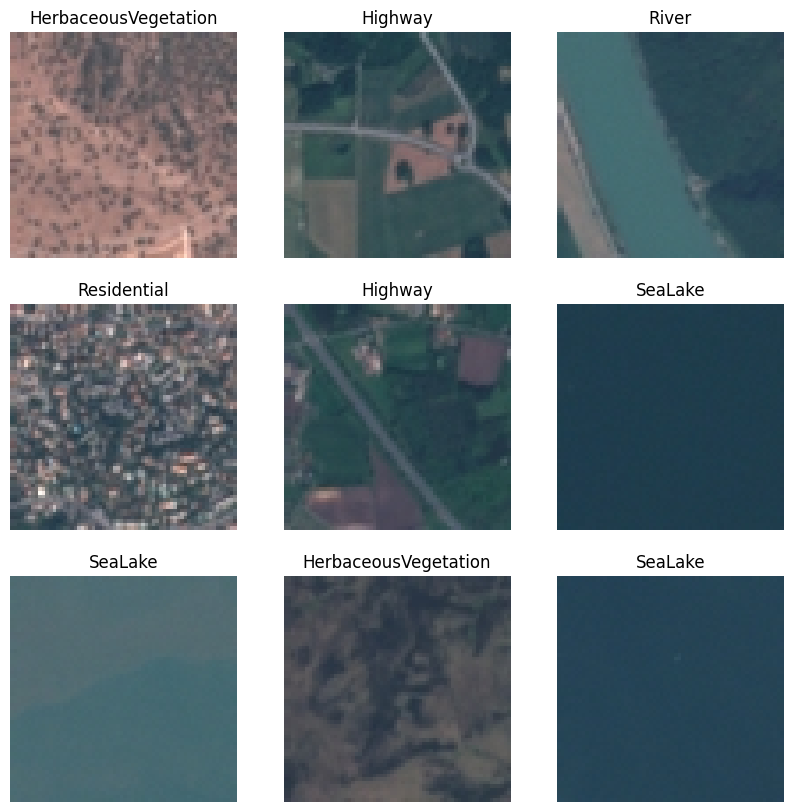

In [ ]:
#visualize data to check correctness
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[labels[i]])
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
#see batched labels
for images, labels in train.take(1):
  for i in range(1):
    print(labels)

tf.Tensor([1 3 9 2 1 2 1 6 9 9 5 0 6 0 0 2 9 1 2 1 3 9 9 7 4 3 9 8 8 1 1 0], shape=(32,), dtype=int32)


In [ ]:
#one-hot encoder for datasets
def _map_func(image, label):
  label = one_hot(label, 10)
  return image, label

In [ ]:
train_oh = train.map(_map_func)
test_oh = test.map(_map_func)

In [ ]:
#check that one-hot worked
for images, labels in train_oh.take(1):
  for i in range(1):
    print(labels)

tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

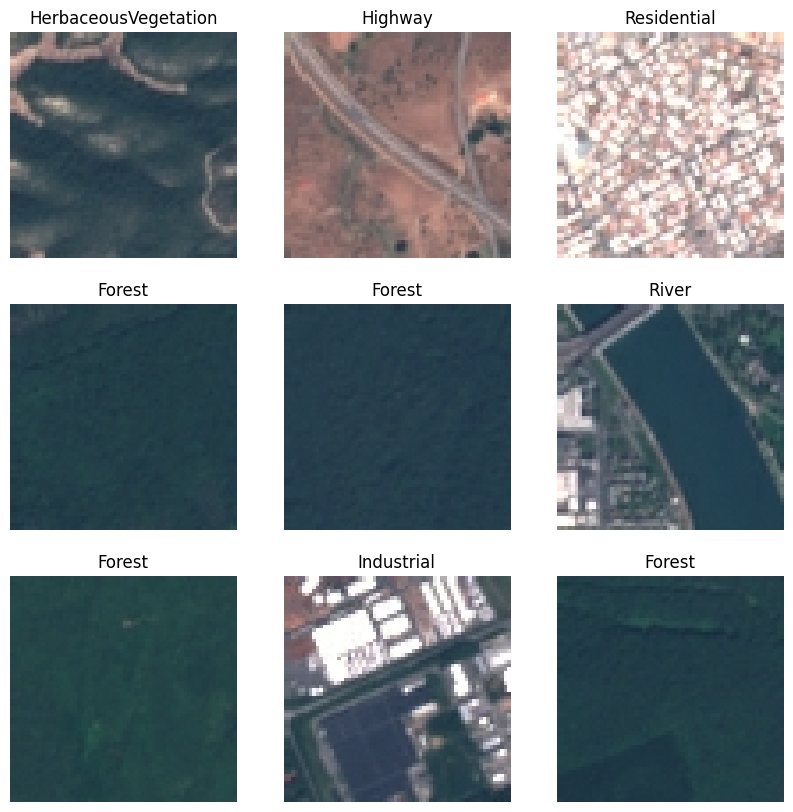

In [ ]:
#visualize one-hot encoded data to make sure we got the labels right
plt.figure(figsize=(10, 10))
for images, labels in train_oh.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.where(labels ==1)[1][i]])
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

### Results visualizer

In [ ]:
#define results visualizer

def pr_cm_roc(y_true, y_pred, pred_probas, test_or_train=["Test", "Train"]):

    classes = {0:'AnnualCrop',
           1:'Forest',
           2:'HerbaceousVegetation',
           3:'Highway',
           4:'Industrial',
           5:'Pasture',
           6:'PermanentCrop',
           7:'Residential',
           8:'River',
           9:'SeaLake'}

    # Classification report
    targets = list(classes.values())
    print(f"CLASSIFICATION REPORT: {test_or_train}")
    print(classification_report(y_true, y_pred, target_names=targets, zero_division=0))

    fig, axs = plt.subplots(1,2, figsize=(12,5))

    # Plot confusion matrix
    sns.heatmap(
        data=confusion_matrix(y_true, y_pred),
        annot=True,
        cmap="Blues",
        linecolor="black",
        linewidths=2,
        fmt=".0f",
        cbar=False,
        ax=axs[0]
    )

    axs[0].set_xticklabels('')
    axs[0].set_yticklabels('')
    axs[0].set_xticks([n + 0.5 for n in range(10)], labels=targets, rotation=270, minor=False)
    axs[0].set_yticks([n + 0.5 for n in range(10)], labels=targets, rotation=0, minor=False)

    axs[0].set_xlabel("Predicted", fontsize=12)
    axs[0].set_ylabel("Actual", fontsize=12)
    axs[0].set_title(f"Confusion Matrix: {test_or_train}", y=1.02, fontsize=18)

    # Plot ROC
    label_binarizer = LabelBinarizer().fit(y_true)
    y_onehot = label_binarizer.transform(y_true)

    for c in range(10):

        class_id = np.flatnonzero(label_binarizer.classes_ == c)[0]

        RocCurveDisplay.from_predictions(
            y_onehot[:, class_id],
            pred_probas[:, class_id],
            name=f"{classes[c]}",
            color=plt.cm.tab10(c),
            ax=axs[1]
        )
        axs[1].set_xlabel("False Positive Rate", fontsize=12)
        axs[1].set_ylabel("True Positive Rate", fontsize=12)
        axs[1].set_title(f"One-vs-Rest ROC curves: {test_or_train}", y=1.02, fontsize=18)
        axs[1].legend(bbox_to_anchor=(1.04, 1), loc="upper left")

    axs[1].plot([0, 1], [0, 1], "--", label="Chance", color="black", linewidth=4)

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

## Custom Neural Network

In [ ]:
#define model builder

num_outputs = len(class_names)

def make_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return tf.keras.Model(inputs, outputs)


model = make_model(input_shape=(64,64,3), num_classes=10)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 64, 64, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 128)  3584        ['rescaling[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 128)  512        ['conv2d[0][0]']                 
 alization)                                                                                 

In [ ]:
#training step
epochs = 10

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_oh,
    epochs=epochs,
    validation_data=test_oh,
)

Epoch 1/10
675/675 [==============================] - 64s 75ms/step - loss: 0.7952 - accuracy: 0.7286 - val_loss: 1.4795 - val_accuracy: 0.5431
Epoch 2/10
675/675 [==============================] - 50s 74ms/step - loss: 0.4225 - accuracy: 0.8570 - val_loss: 4.8026 - val_accuracy: 0.2237
Epoch 3/10
675/675 [==============================] - 49s 73ms/step - loss: 0.3036 - accuracy: 0.8970 - val_loss: 0.6578 - val_accuracy: 0.8128
Epoch 4/10
675/675 [==============================] - 44s 66ms/step - loss: 0.2363 - accuracy: 0.9190 - val_loss: 1.0062 - val_accuracy: 0.7213
Epoch 5/10
675/675 [==============================] - 52s 77ms/step - loss: 0.2087 - accuracy: 0.9304 - val_loss: 1.4411 - val_accuracy: 0.7126
Epoch 6/10
675/675 [==============================] - 53s 78ms/step - loss: 0.1744 - accuracy: 0.9397 - val_loss: 0.7060 - val_accuracy: 0.7976
Epoch 7/10
675/675 [==============================] - 53s 79ms/step - loss: 0.1670 - accuracy: 0.9416 - val_loss: 0.4111 - val_accuracy:

In [ ]:
#save model
model.save("/content/drive/MyDrive/satellite_data/first_model")

In [ ]:
#save our model. Uncomment below if necessary
#reconstructed_model = models.load_model("/content/drive/MyDrive/satellite_data/first_model")

In [ ]:
#pull images and labels from our dataset to keep them stable
images, labels = zip(*[(x, y) for x, y in train_oh.unbatch()])

In [ ]:
#check to make sure its working
print(np.array(images).shape) #image shapes
print(np.argmax(np.array(labels),axis=1)) #labels

(21600, 64, 64, 3)

In [ ]:
#predict
preds = reconstructed_model.predict(np.array(images))

675/675 [==============================] - 8s 11ms/step


CLASSIFICATION REPORT: Test
                      precision    recall  f1-score   support

          AnnualCrop       0.80      0.98      0.88      2422
              Forest       0.98      0.98      0.98      2396
HerbaceousVegetation       0.85      0.89      0.87      2399
             Highway       0.93      0.97      0.95      1976
          Industrial       0.96      0.99      0.97      2007
             Pasture       0.98      0.90      0.94      1606
       PermanentCrop       1.00      0.55      0.71      1986
         Residential       0.99      1.00      0.99      2412
               River       0.99      0.94      0.96      1998
             SeaLake       0.88      1.00      0.94      2398

            accuracy                           0.92     21600
           macro avg       0.94      0.92      0.92     21600
        weighted avg       0.93      0.92      0.92     21600



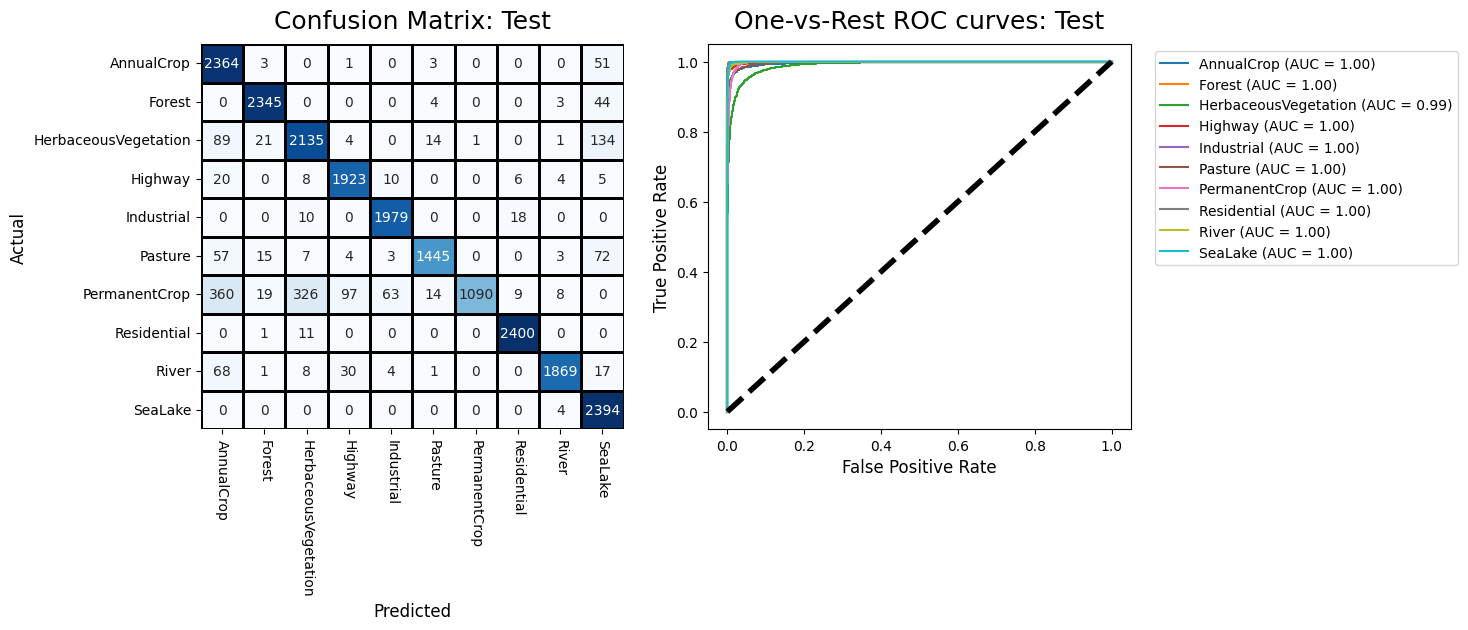

In [ ]:
#visualize results
pr_cm_roc(np.argmax(np.array(labels),axis=1),
          np.argmax(preds, axis=1),
          preds, test_or_train="Test")

## Resnet 152

In [ ]:
from tensorflow.keras.applications import ResNet152V2

In [ ]:
#load in the pre-trained resnet model
tf.keras.applications.ResNet152V2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

NameError: ignored

In [ ]:
base_model = ResNet152V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(64, 64, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = Input(shape=(64, 64, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = layers.Dense(10, activation="softmax")(x)
model = Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 resnet152v2 (Functional)    (None, 2, 2, 2048)        58331648  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                20490     
                                                           

In [ ]:
#compile and train
model.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"],
)

epochs = 20
model.fit(train_oh,
          epochs = epochs,
          validation_data = test_oh)

Epoch 1/20
675/675 [==============================] - 82s 95ms/step - loss: 1.0340 - accuracy: 0.7173 - val_loss: 0.7719 - val_accuracy: 0.7876
Epoch 2/20
675/675 [==============================] - 52s 78ms/step - loss: 0.6790 - accuracy: 0.8034 - val_loss: 0.6959 - val_accuracy: 0.8065
Epoch 3/20
675/675 [==============================] - 51s 75ms/step - loss: 0.5839 - accuracy: 0.8214 - val_loss: 0.6736 - val_accuracy: 0.8122
Epoch 4/20
675/675 [==============================] - 56s 83ms/step - loss: 0.5460 - accuracy: 0.8337 - val_loss: 0.6620 - val_accuracy: 0.8137
Epoch 5/20
675/675 [==============================] - 47s 70ms/step - loss: 0.5002 - accuracy: 0.8438 - val_loss: 0.6510 - val_accuracy: 0.8185
Epoch 6/20
675/675 [==============================] - 48s 70ms/step - loss: 0.4832 - accuracy: 0.8493 - val_loss: 0.6590 - val_accuracy: 0.8204
Epoch 7/20
675/675 [==============================] - 51s 76ms/step - loss: 0.4635 - accuracy: 0.8528 - val_loss: 0.6628 - val_accuracy:

In [ ]:
#save model
model.save("/content/drive/MyDrive/satellite_data/resnet152_untuned")

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 resnet152v2 (Functional)    (None, 2, 2, 2048)        58331648  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                20490     
                                                           

In [ ]:
model.compile(
    optimizer = optimizers.Adam(1e-5),  # Low learning rate
    loss = "categorical_crossentropy",
    metrics = ["accuracy"],
)

epochs = 10
model.fit(train_oh,
          epochs = epochs,
          validation_data = test_oh)

Epoch 1/10
675/675 [==============================] - 278s 260ms/step - loss: 0.3077 - accuracy: 0.9028 - val_loss: 0.2528 - val_accuracy: 0.9228
Epoch 2/10
675/675 [==============================] - 109s 162ms/step - loss: 0.1192 - accuracy: 0.9588 - val_loss: 0.2345 - val_accuracy: 0.9317
Epoch 3/10
675/675 [==============================] - 101s 150ms/step - loss: 0.0652 - accuracy: 0.9783 - val_loss: 0.2245 - val_accuracy: 0.9422
Epoch 4/10
675/675 [==============================] - 106s 157ms/step - loss: 0.0546 - accuracy: 0.9815 - val_loss: 0.2524 - val_accuracy: 0.9352
Epoch 5/10
675/675 [==============================] - 107s 159ms/step - loss: 0.0436 - accuracy: 0.9851 - val_loss: 0.2349 - val_accuracy: 0.9430
Epoch 6/10
675/675 [==============================] - 105s 156ms/step - loss: 0.0234 - accuracy: 0.9925 - val_loss: 0.2749 - val_accuracy: 0.9407
Epoch 7/10
675/675 [==============================] - 102s 151ms/step - loss: 0.0271 - accuracy: 0.9909 - val_loss: 0.2325 -

In [ ]:
model.save("/content/drive/MyDrive/satellite_data/resnet152_tuned")

In [ ]:
images, labels = zip(*[(x, y) for x, y in train_oh.unbatch()])

In [ ]:
preds = model.predict(np.array(images))

675/675 [==============================] - 26s 34ms/step


CLASSIFICATION REPORT: Test
                      precision    recall  f1-score   support

          AnnualCrop       1.00      1.00      1.00      2422
              Forest       1.00      1.00      1.00      2396
HerbaceousVegetation       0.99      1.00      0.99      2399
             Highway       1.00      0.99      1.00      1976
          Industrial       1.00      0.98      0.99      2007
             Pasture       0.99      1.00      0.99      1606
       PermanentCrop       1.00      0.99      0.99      1986
         Residential       0.98      1.00      0.99      2412
               River       1.00      1.00      1.00      1998
             SeaLake       1.00      1.00      1.00      2398

            accuracy                           1.00     21600
           macro avg       1.00      0.99      1.00     21600
        weighted avg       1.00      1.00      1.00     21600



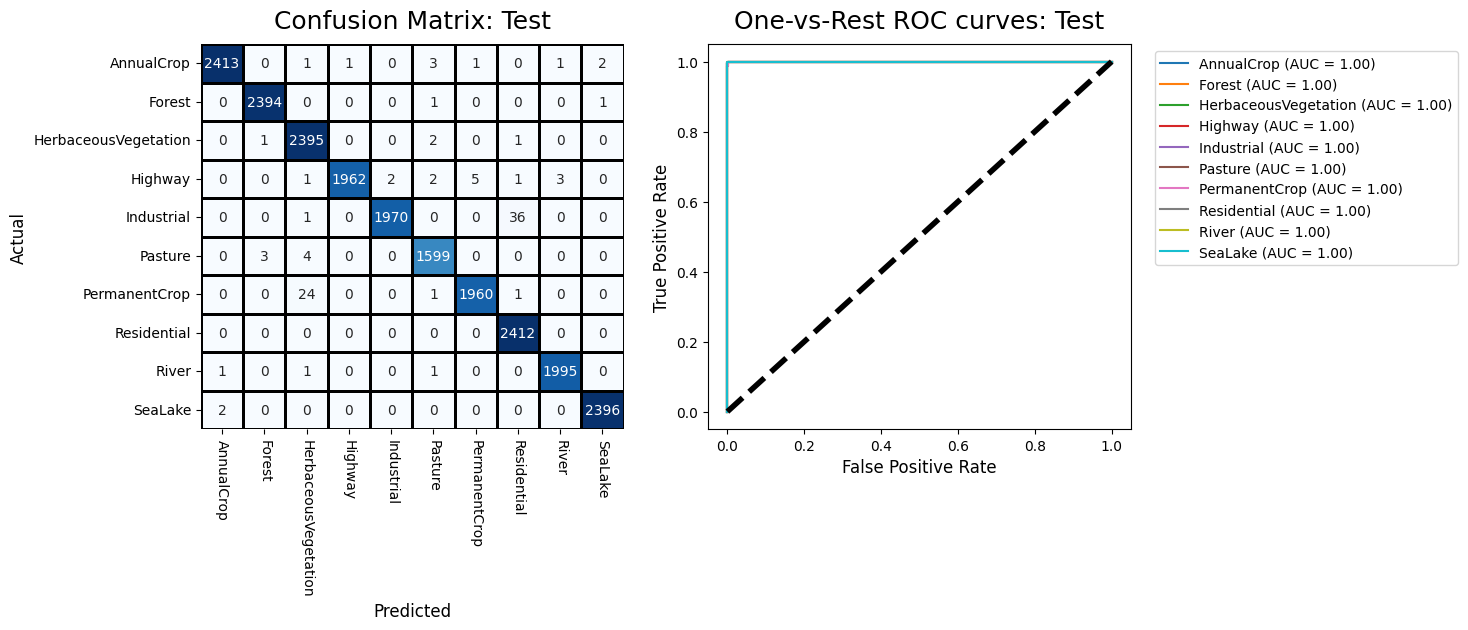

In [ ]:
#visualize results
pr_cm_roc(np.argmax(np.array(labels),axis=1),
          np.argmax(preds, axis=1),
          preds, test_or_train="Test")

# Model Application

## Test Image

In [ ]:
from tensorflow.keras.utils import load_img

In [ ]:
#import and extract zip file
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/satellite_data/sample_tiles2/Test2.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
#pull image and check shape
img = load_img(
    "/tmp/Test- 14/clip6.png"
)

img = np.array(img)
img.shape

(2048, 2048, 3)

In [ ]:
#make M by N tiles from the photo
M = 64
N = 64
tiles = [img[x:x+M,y:y+N,:] for x in range(0,img.shape[0],M) for y in range(0,img.shape[1],N)]

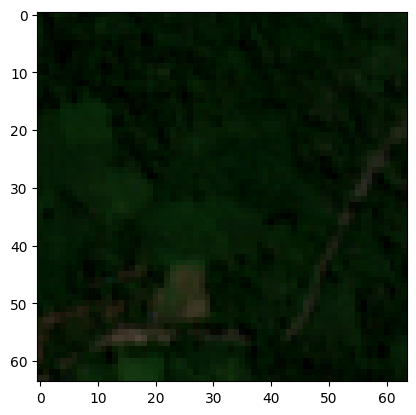

In [ ]:
#visualize one of the tiles we made
plt.imshow(np.array(tiles)[99].astype("uint8"))

In [ ]:
#load in our model
reconstructed_model = models.load_model("/content/drive/MyDrive/satellite_data/first_model")

In [ ]:
#conduct prediction using reconstructed model
prediction = reconstructed_model.predict(np.array(tiles)[98:99])

1/1 [==============================] - 8s 8s/step


In [ ]:
np.array(tiles).dtype

dtype('uint8')

In [ ]:
np.array(tiles).shape

(1024, 64, 64, 3)

In [ ]:
#print out prediction
class_names[np.argmax(prediction)]

'Forest'

## 2020 Data

Projection used in Sentinel: UTM/WGS84

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models
import random

In [ ]:
#import and extract zip file
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/satellite_data/Raster_2020.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
#load gdal api and read in the tif file
from osgeo import gdal
raster = gdal.Open('/tmp/Raster_2020/ketapang_m1_mean_clip4.tif')

In [ ]:
type(raster)

osgeo.gdal.Dataset

In [ ]:
b1 = raster.GetRasterBand(1).ReadAsArray() # red
b2 = raster.GetRasterBand(2).ReadAsArray() # green
b3 = raster.GetRasterBand(3).ReadAsArray() # blue

In [ ]:
#image shape
b1.shape

(30381, 17156)

In [ ]:
#assemble normal 3-channel image
img = np.dstack((b1, b2, b3))

#save RAM space
del b1
del b2
del b3

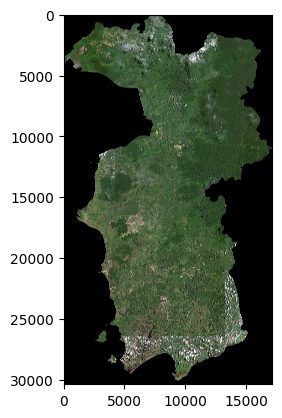

In [ ]:
#plot the entire image
f = plt.figure()
plt.imshow(img)
plt.savefig('/content/drive/MyDrive/satellite_data/raster_mosaic_v6_first.png')
plt.show()

In [ ]:
#saving RAM
del f

In [ ]:
#projection information
raster.GetProjection()

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

In [ ]:
#inspecting some random values
img[10000,10000:10012,:]

array([[128, 127,  99],
       [123, 121,  94],
       [113, 124,  98],
       [106, 116,  88],
       [ 91, 108,  68],
       [ 79, 105,  67],
       [ 69,  98,  70],
       [ 49,  76,  47],
       [ 50,  77,  43],
       [ 61, 100,  54],
       [ 56, 103,  53],
       [ 49,  83,  39]], dtype=uint8)

In [ ]:
#clip the image so it's divisible by 64
img = img[0:img.shape[0]-(img.shape[0]%64),0:img.shape[1]-(img.shape[1]%64),:]

#make 64 x 64 tiles from the raster image
tiles = np.array([img[x:x+64,y:y+64,:] for x in range(0,img.shape[0],64) for y in range(0,img.shape[1],64)])

In [ ]:
#total number of tiles
tiles.shape

(127032, 64, 64, 3)

In [ ]:
#data type in tiles
tiles[1].dtype

dtype('uint8')

### Image Map

In [ ]:
#determine which of the tiles contain actual image data
image_map = np.array([0 not in np.sum(tiles[i], axis = 2) for i in range(0,len(tiles))]).astype(int)

In [ ]:
#total number of image tiles
np.sum(image_map)

60915

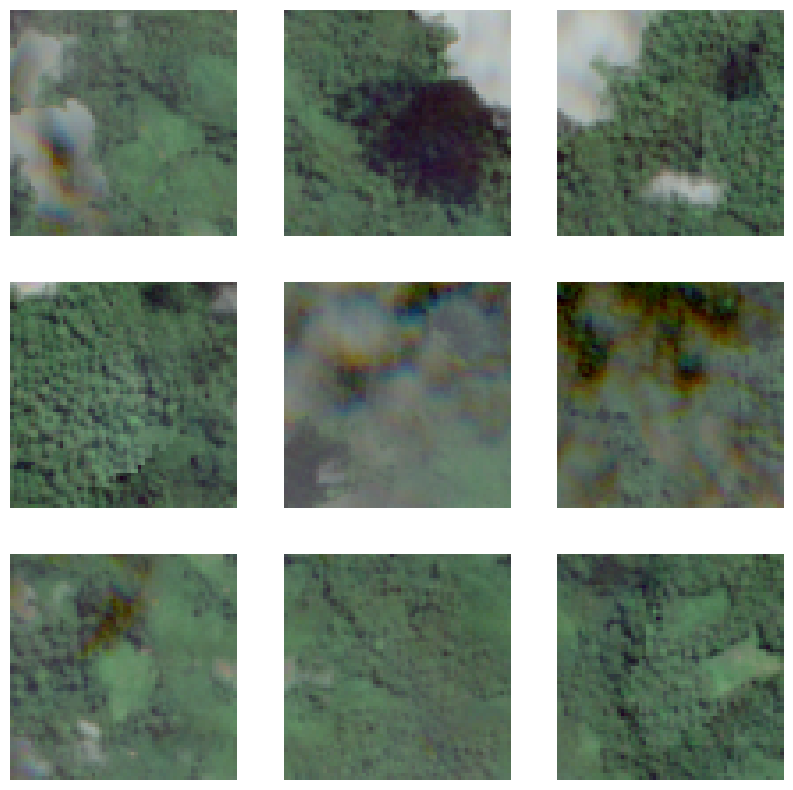

In [ ]:
#visualize our image-filtered images to make sure our image detector is working
plt.figure(figsize=(10, 10))
for tile in tiles[np.where(image_map == 1)[0]][0:9]:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(tiles[np.where(image_map == 1)[0]][i].astype("uint8"))
    plt.axis("off")

### Cloud Detector

134.17423502604166


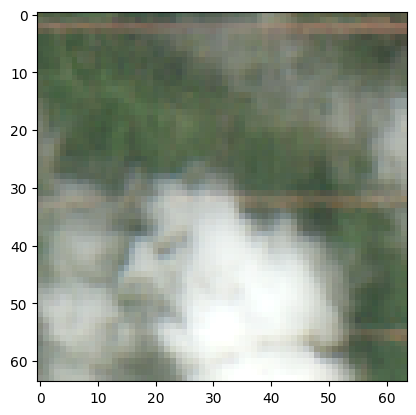

In [ ]:
#randomly sorted through images until a small cloud is found, and print out the mean pixel value
plt.imshow(tiles[51779])
print(np.mean(tiles[51779]))

In [ ]:
#create a filter for tiles that likely contain clouds, choosing a mean
#pixel value cutoff and tuning by looking at the results in the below step
cloud_map = np.array([np.mean(tiles[i]) > 94 for i in range(0,len(tiles))]).astype(int)

In [ ]:
#total number of cloud pictures
np.sum(cloud_map)

9990

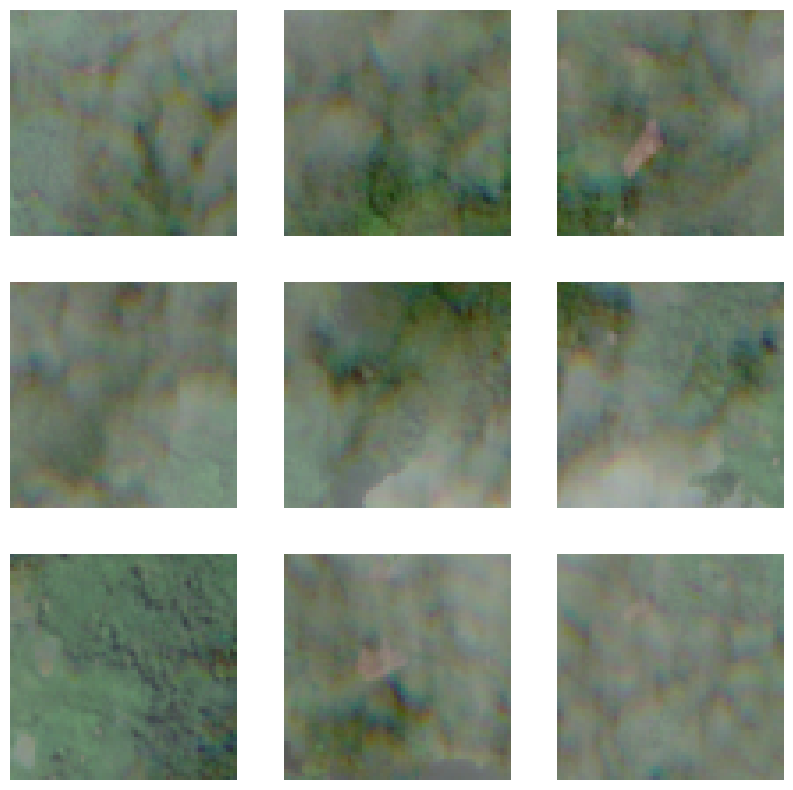

In [ ]:
#visualize our cloud-filtered images to make sure our cloud detector is working
plt.figure(figsize=(10, 10))
for tile in tiles[np.where(cloud_map == 1)[0]][0:9]:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(tiles[np.where(cloud_map == 1)[0]][i+70].astype("uint8"))
    plt.axis("off")

### Prediction of Results

In [ ]:
#load in our model
reconstructed_model = models.load_model("/content/drive/MyDrive/satellite_data/resnet152_tuned")

In [ ]:
#choose tiles that are images and contain no clouds
tile_chooser = image_map * 1-cloud_map

In [ ]:
#conduct prediction using reconstructed model
predictions = reconstructed_model.predict(tiles[np.where(tile_chooser == 1)[0]])

1599/1599 [==============================] - 78s 40ms/step


In [ ]:
predictions.shape

(51149, 10)

In [ ]:
class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

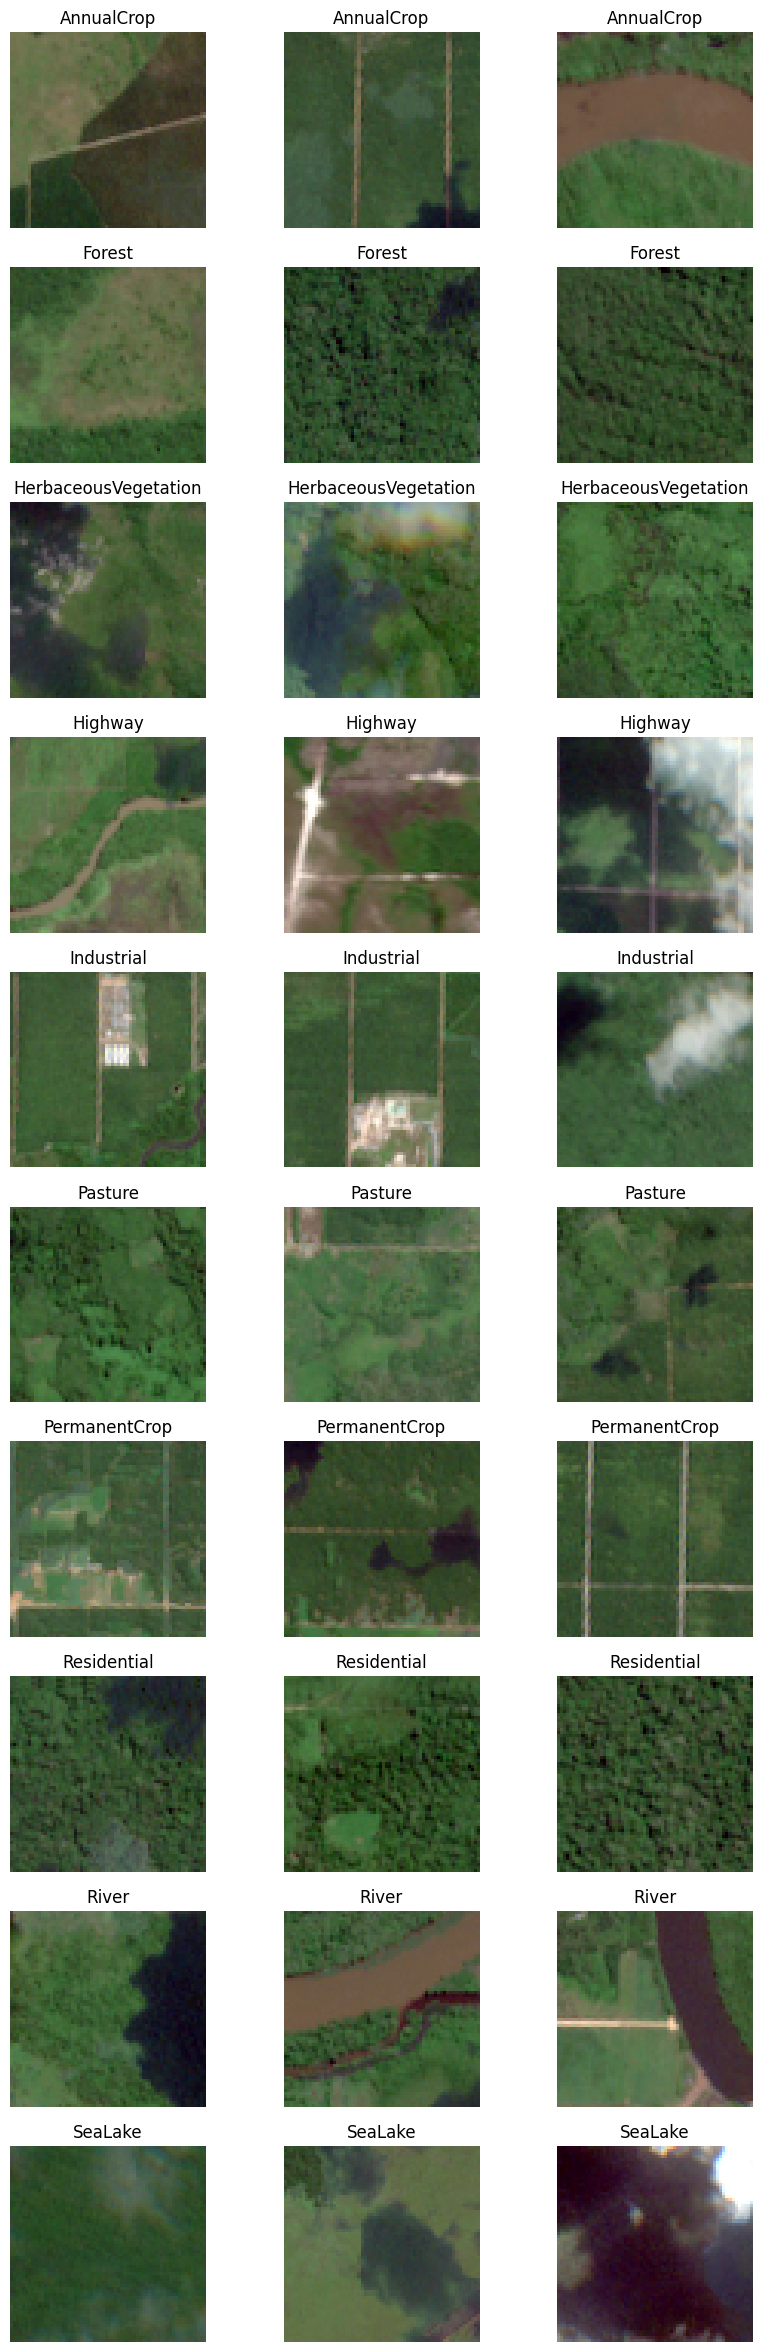

In [ ]:
#visualizing results by class...

plt.figure(figsize=(10, 30))
class_number = 0
count = 1
for i in range(10):
  for j in range(3):
    ax = plt.subplot(10, 3, count)
    n = random.choice(np.where(np.argmax(predictions, axis = 1) == class_number)[0])
    plt.title(class_names[np.argmax(predictions[n,:])])
    plt.imshow(tiles[np.where(tile_chooser == 1)[0]][n])
    plt.axis("off")
    count+=1
  class_number += 1

<function matplotlib.pyplot.show(close=None, block=None)>

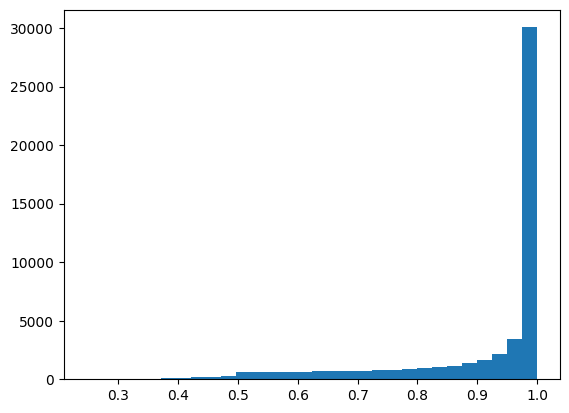

In [ ]:
plt.hist(np.max(predictions, axis=1), bins = 30)
plt.show

In [ ]:
confident_predictions = predictions[np.where(np.max(predictions, axis=1) > 0.95)]

In [ ]:
confident_predictions.shape

(33480, 10)

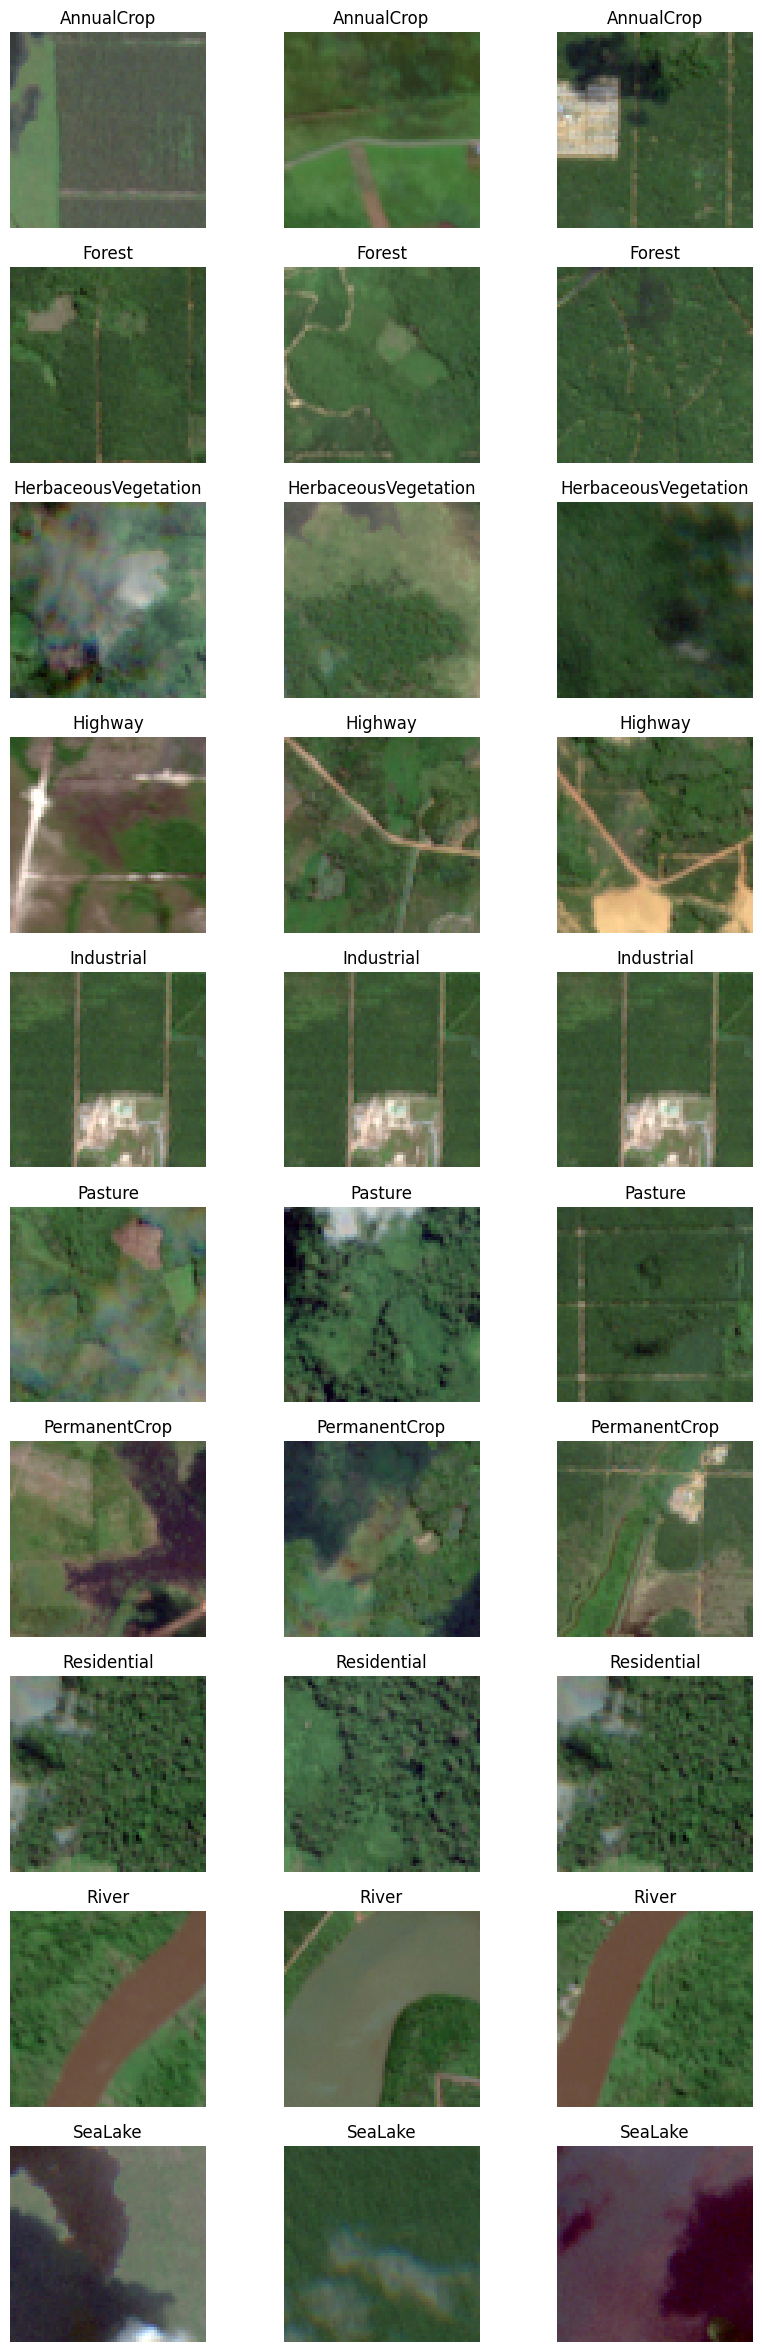

In [ ]:
#visualizing results by class where the algorithm is more confident

plt.figure(figsize=(10, 30))
class_number = 0
count = 1
for i in range(10):
  for j in range(3):
    ax = plt.subplot(10, 3, count)
    n = random.choice(np.where(np.argmax(confident_predictions, axis = 1) == class_number)[0])
    plt.title(class_names[np.argmax(confident_predictions[n,:])])
    plt.imshow(tiles[np.where(tile_chooser == 1)[0]][np.where(np.max(predictions, axis=1) > 0.95)][n])
    plt.axis("off")
    count+=1
  class_number += 1

In [ ]:
#delete image data to save space
del raster
del tiles

In [ ]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 50.7 MB/s eta 0:00:00


In [ ]:
import rasterio

In [ ]:
#find the coordinates corresponding to each tile location in the image

with rasterio.open("/tmp/Raster_2020/ketapang_m1_mean_clip4.tif") as src:
  band1 = src.read(1)
  print('Band1 has shape', band1.shape)
  height = band1.shape[0] - band1.shape[0]%64
  width = band1.shape[1] - band1.shape[1]%64
  cols, rows = np.meshgrid(np.arange(width, step = 64), np.arange(height, step = 64))
  xs, ys = rasterio.transform.xy(src.transform, rows, cols)
  lons= np.array(xs)
  lats = np.array(ys)
  print('lons shape', lons.shape)

Band1 has shape (30381, 17156)
lons shape (474, 268)


In [ ]:
#find the coordinates that correspond to our predictions, and combine into a single array
pred_lons = lons.reshape(tile_chooser.shape)[np.where(tile_chooser == 1)]
pred_lats = lats.reshape(tile_chooser.shape)[np.where(tile_chooser == 1)]
coords_2020 = np.vstack((pred_lons, pred_lats)).T

In [ ]:
#save our outputs for later work
np.save('/content/drive/MyDrive/satellite_data/results/2020_preds.npy', predictions)
np.save('/content/drive/MyDrive/satellite_data/results/2020_coords.npy', coords_2020)
np.save('/content/drive/MyDrive/satellite_data/results/2020_chooser.npy', tile_chooser)

## 2023 Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models
import random

In [ ]:
#import and extract zip file
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/satellite_data/Raster_2023.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
#load gdal api and read in the tif file
from osgeo import gdal
raster = gdal.Open('/tmp/Raster_2023/ketapang_mosaic_mean_v10.tif')

In [ ]:
b1 = raster.GetRasterBand(1).ReadAsArray() # red
b2 = raster.GetRasterBand(2).ReadAsArray() # green
b3 = raster.GetRasterBand(3).ReadAsArray() # blue

In [ ]:
#assemble normal 3-channel image
img = np.dstack((b1, b2, b3))

#save RAM space
del b1
del b2
del b3

In [ ]:
#projection information
raster.GetProjection()

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

In [ ]:
#clip the image so it's divisible by 64
img = img[0:img.shape[0]-(img.shape[0]%64),0:img.shape[1]-(img.shape[1]%64),:]

#make 64 x 64 tiles from the raster image
tiles = np.array([img[x:x+64,y:y+64,:] for x in range(0,img.shape[0],64) for y in range(0,img.shape[1],64)])

### Image Map

In [ ]:
#determine which of the tiles contain actual image data
image_map = np.array([0 not in np.sum(tiles[i], axis = 2) for i in range(0,len(tiles))]).astype(int)

In [ ]:
#total number of images
np.sum(image_map)

61384

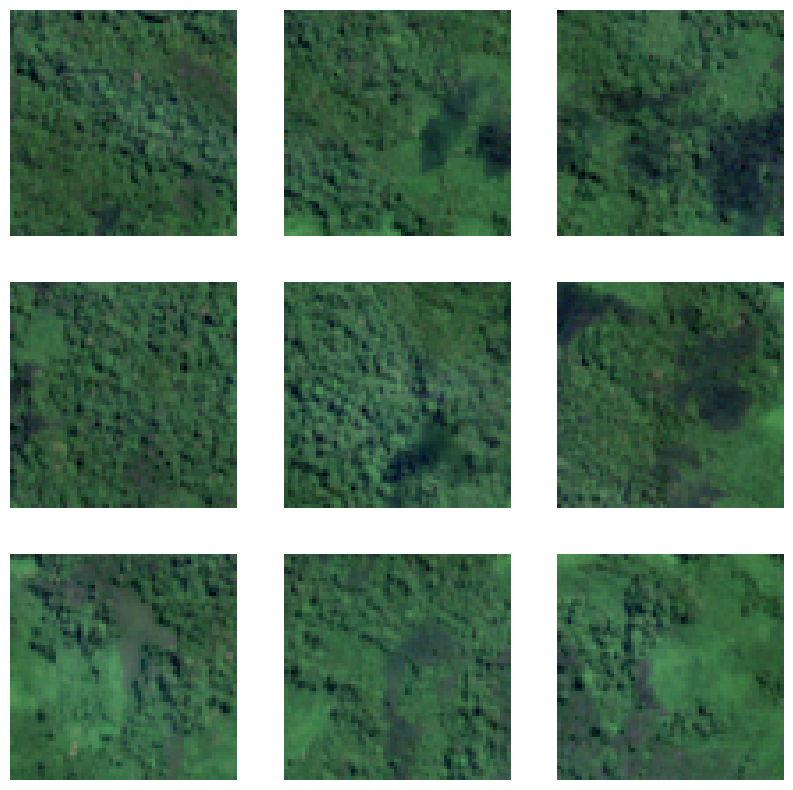

In [ ]:
#visualize our image-filtered images to make sure our image detector is working
plt.figure(figsize=(10, 10))
for tile in tiles[np.where(image_map == 1)[0]][0:9]:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(tiles[np.where(image_map == 1)[0]][i].astype("uint8"))
    plt.axis("off")

### Cloud Detector

In [ ]:
#create a filter for tiles that likely contain clouds, choosing a mean
#pixel value cutoff and tuning by looking at the results in the below step
cloud_map = np.array([np.mean(tiles[i]) > 94 for i in range(0,len(tiles))]).astype(int)

In [ ]:
#total number of cloud pictures
np.sum(cloud_map)

6290

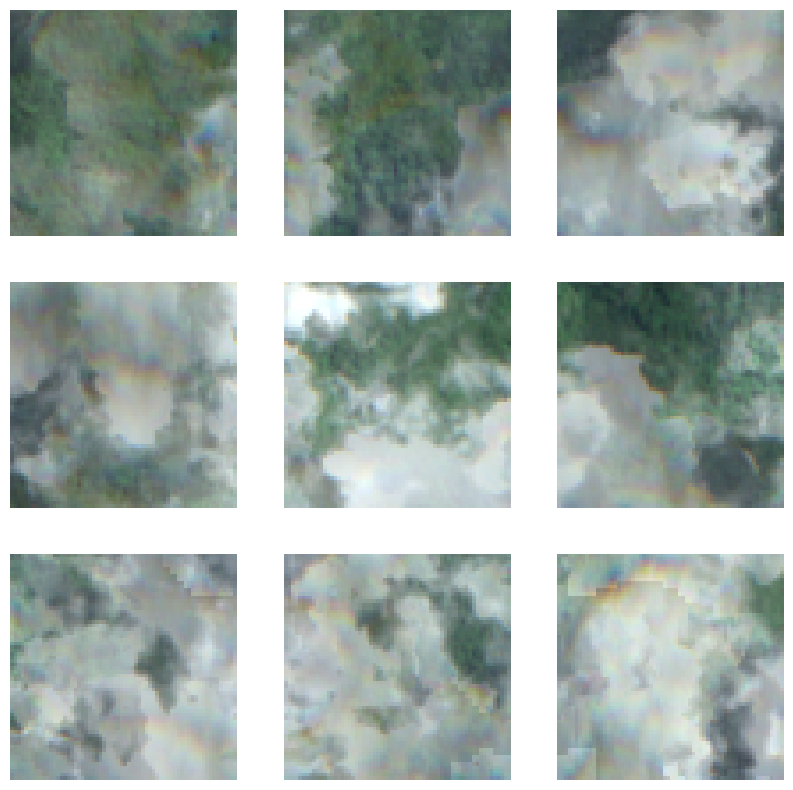

In [ ]:
#visualize our cloud-filtered images to make sure our cloud detector is working
plt.figure(figsize=(10, 10))
for tile in tiles[np.where(cloud_map == 1)[0]][0:9]:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(tiles[np.where(cloud_map == 1)[0]][i+70].astype("uint8"))
    plt.axis("off")

### Prediction of Results

In [ ]:
#load in our model
reconstructed_model = models.load_model("/content/drive/MyDrive/satellite_data/resnet152_tuned")

In [ ]:
#choose tiles that are images and contain no clouds
tile_chooser = image_map * 1-cloud_map

In [ ]:
#conduct prediction using reconstructed model
predictions = reconstructed_model.predict(tiles[np.where(tile_chooser == 1)[0]])

1732/1732 [==============================] - 127s 64ms/step


In [ ]:
predictions.shape

(55405, 10)

In [ ]:
class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

<function matplotlib.pyplot.show(close=None, block=None)>

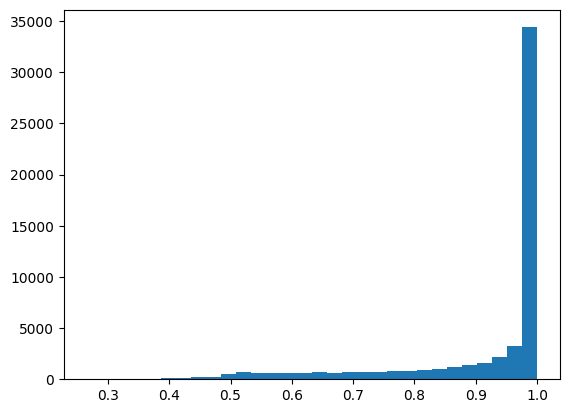

In [ ]:
plt.hist(np.max(predictions, axis=1), bins = 30)
plt.show

In [ ]:
confident_predictions = predictions[np.where(np.max(predictions, axis=1) > 0.95)]

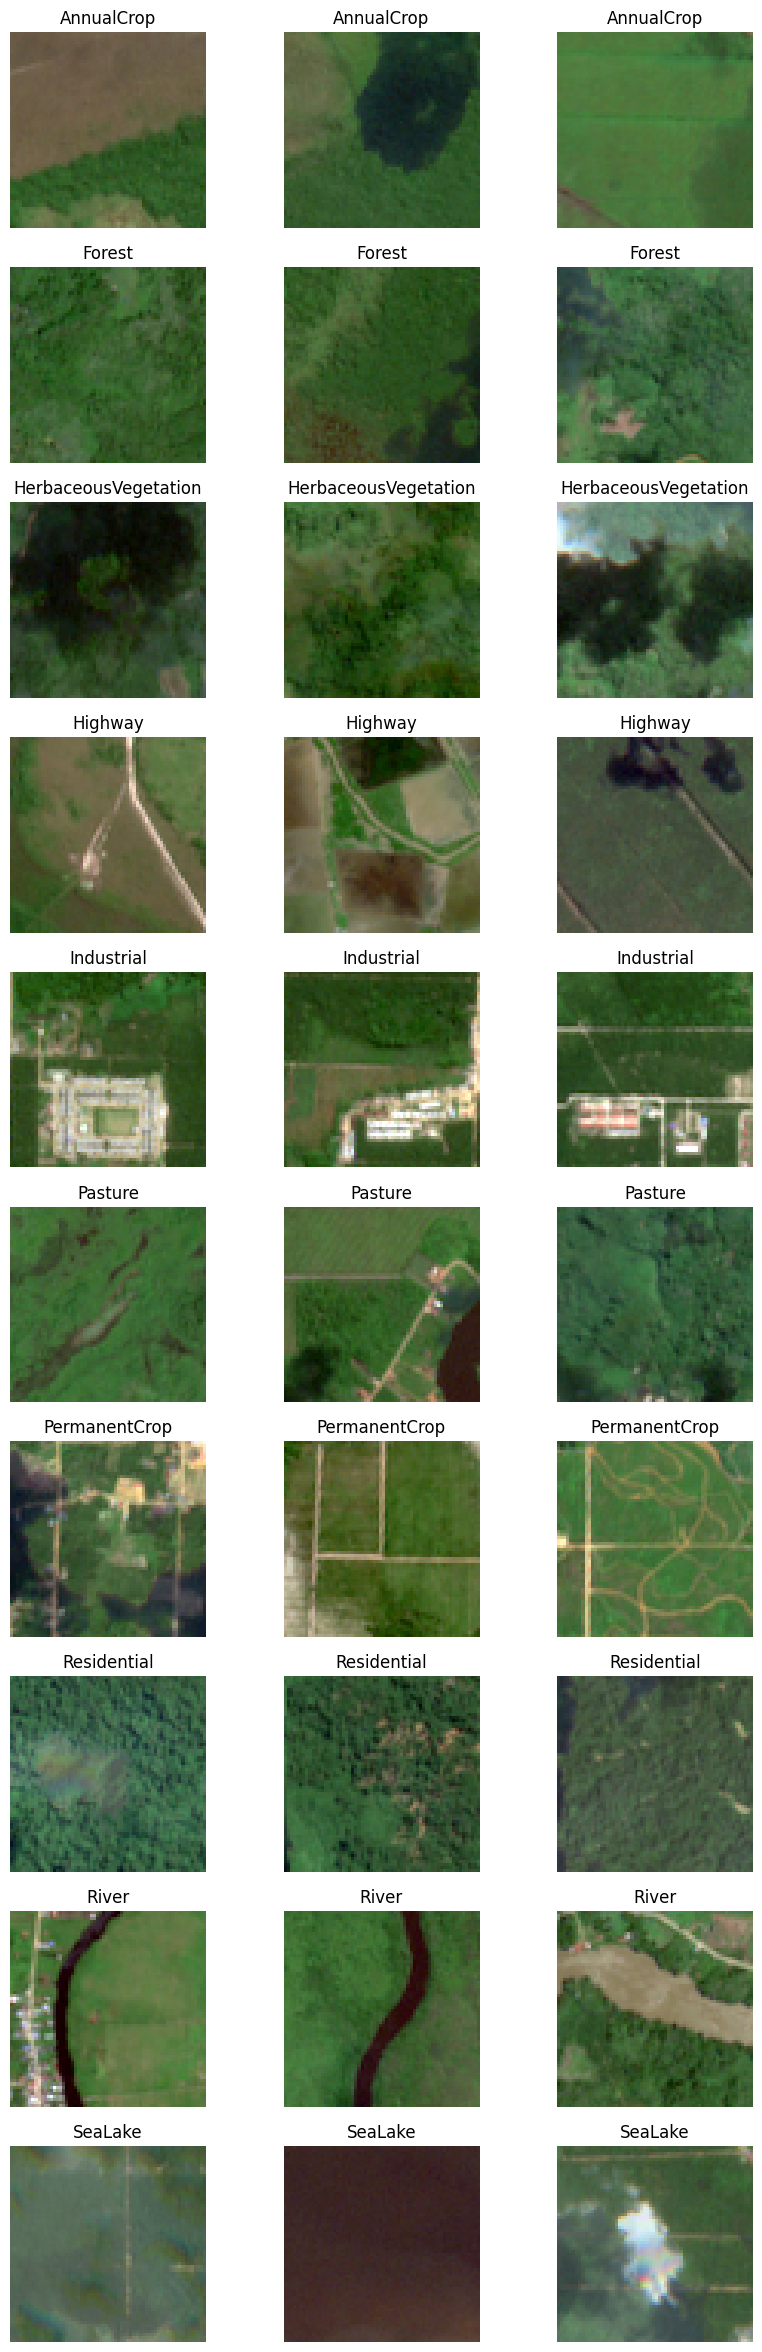

In [ ]:
#visualizing results by class where the algorithm is more confident

plt.figure(figsize=(10, 30))
class_number = 0
count = 1
for i in range(10):
  for j in range(3):
    ax = plt.subplot(10, 3, count)
    n = random.choice(np.where(np.argmax(confident_predictions, axis = 1) == class_number)[0])
    plt.title(class_names[np.argmax(confident_predictions[n,:])])
    plt.imshow(tiles[np.where(tile_chooser == 1)[0]][np.where(np.max(predictions, axis=1) > 0.95)][n])
    plt.axis("off")
    count+=1
  class_number += 1

In [ ]:
#delete image data to save space
del raster
del tiles

In [ ]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 48.7 MB/s eta 0:00:00


In [ ]:
import rasterio

In [ ]:
#find the coordinates corresponding to each tile location in the image

with rasterio.open("/tmp/Raster_2023/ketapang_mosaic_mean_v10.tif") as src:
  band1 = src.read(1)
  print('Band1 has shape', band1.shape)
  height = band1.shape[0] - band1.shape[0]%64
  width = band1.shape[1] - band1.shape[1]%64
  cols, rows = np.meshgrid(np.arange(width, step = 64), np.arange(height, step = 64))
  xs, ys = rasterio.transform.xy(src.transform, rows, cols)
  lons= np.array(xs)
  lats = np.array(ys)
  print('lons shape', lons.shape)

Band1 has shape (30381, 17156)
lons shape (474, 268)


In [ ]:
#find the coordinates that correspond to our predictions, and combine into a single array
pred_lons = lons.reshape(tile_chooser.shape)[np.where(tile_chooser == 1)]
pred_lats = lats.reshape(tile_chooser.shape)[np.where(tile_chooser == 1)]
coords_2023 = np.vstack((pred_lons, pred_lats)).T

In [ ]:
#save our outputs for later work
np.save('/content/drive/MyDrive/satellite_data/results/2023_preds.npy', predictions)
np.save('/content/drive/MyDrive/satellite_data/results/2023_coords.npy', coords_2023)
np.save('/content/drive/MyDrive/satellite_data/results/2023_chooser.npy', tile_chooser)

## Comparison

In [ ]:
#
predictions_2023 = np.load('/content/drive/MyDrive/satellite_data/results/2023_preds.npy')
coords_2023 = np.load('/content/drive/MyDrive/satellite_data/results/2023_coords.npy')
tile_chooser_2023 = np.load('/content/drive/MyDrive/satellite_data/results/2023_chooser.npy')

predictions_2020 = np.load('/content/drive/MyDrive/satellite_data/results/2020_preds.npy')
coords_2020 = np.load('/content/drive/MyDrive/satellite_data/results/2020_coords.npy')
tile_chooser_2020 = np.load('/content/drive/MyDrive/satellite_data/results/2020_chooser.npy')

In [ ]:
#make a chooser for each that allows us to do an inner join
chooser_2023 = tile_chooser_2020[np.where(tile_chooser_2023 == 1)]
chooser_2020 = tile_chooser_2023[np.where(tile_chooser_2020 == 1)]

In [ ]:
#pull the common predictions, confidence levels, and coordinates
common_preds_2023 = predictions_2023[np.where(chooser_2023 == 1)]
confidence_2023 = np.max(common_preds_2023, axis = 1)
common_preds_2023 = np.argmax(common_preds_2023, axis = 1)

common_preds_2020 = predictions_2020[np.where(chooser_2020 == 1)]
confidence_2020 = np.max(common_preds_2020, axis = 1)
common_preds_2020 = np.argmax(common_preds_2020, axis = 1)

confidences = np.min(np.vstack((confidence_2023, confidence_2020)).T, axis = 1)

common_coords = coords_2023[np.where(chooser_2023 == 1)]


In [ ]:
#combine into a dataset
results = np.hstack((common_preds_2023.reshape((41163,1)),
                      common_preds_2020.reshape((41163,1)),
                      confidences.reshape((41163,1)),
                      common_coords))

class_names:
['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

In [ ]:
#list of classes which would indicate deforestation
non_forest = np.array([0,3,4,5,6])

#reach a map of items that were classified as forest in 2020 and not forest in 2023
forest_2020 = np.array([common_preds_2020[x] == 1 for x in range(0,common_preds_2020.shape[0])]).astype(int)
not_forest_2023 = np.array([common_preds_2023[x] in non_forest for x in range(0,common_preds_2020.shape[0])]).astype(int)
deforestation_map = forest_2020*not_forest_2023

In [ ]:
#number of tiles classified as deforestation
np.sum(deforestation_map)

1803

In [ ]:
deforestation = results[np.where(deforestation_map == 1)]

In [ ]:
#pull the portion of deforestation results where our confidence is relatively high
deforestation_conf = deforestation[np.where(deforestation[:,2] > 0.95)]

In [ ]:
deforestation_conf.shape

(460, 5)

In [ ]:
np.save('/content/drive/MyDrive/satellite_data/results/deforestation.npy', deforestation_conf)

In [ ]:
#uncomment to load in results

#deforestation_conf = np.load('/content/drive/MyDrive/satellite_data/results/deforestation.npy')

In [ ]:
#export to csv
import pandas as pd
pd.DataFrame({'2023_Class': deforestation_conf[:,0].astype('int'),
              'Lat': deforestation_conf[:, 3],
              'Lon': deforestation_conf[:, 4]}).to_csv("/content/drive/MyDrive/satellite_data/results/deforestation.csv")

In [ ]:
#compare resulting images:
tiles[np.where(tile_chooser_2020==1)][np.where(chooser_2020==1)][np.where(deforestation_map==1)][np.where(deforestation[:,2] > 0.95)].shape

(460, 64, 64, 3)

In [ ]:
class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

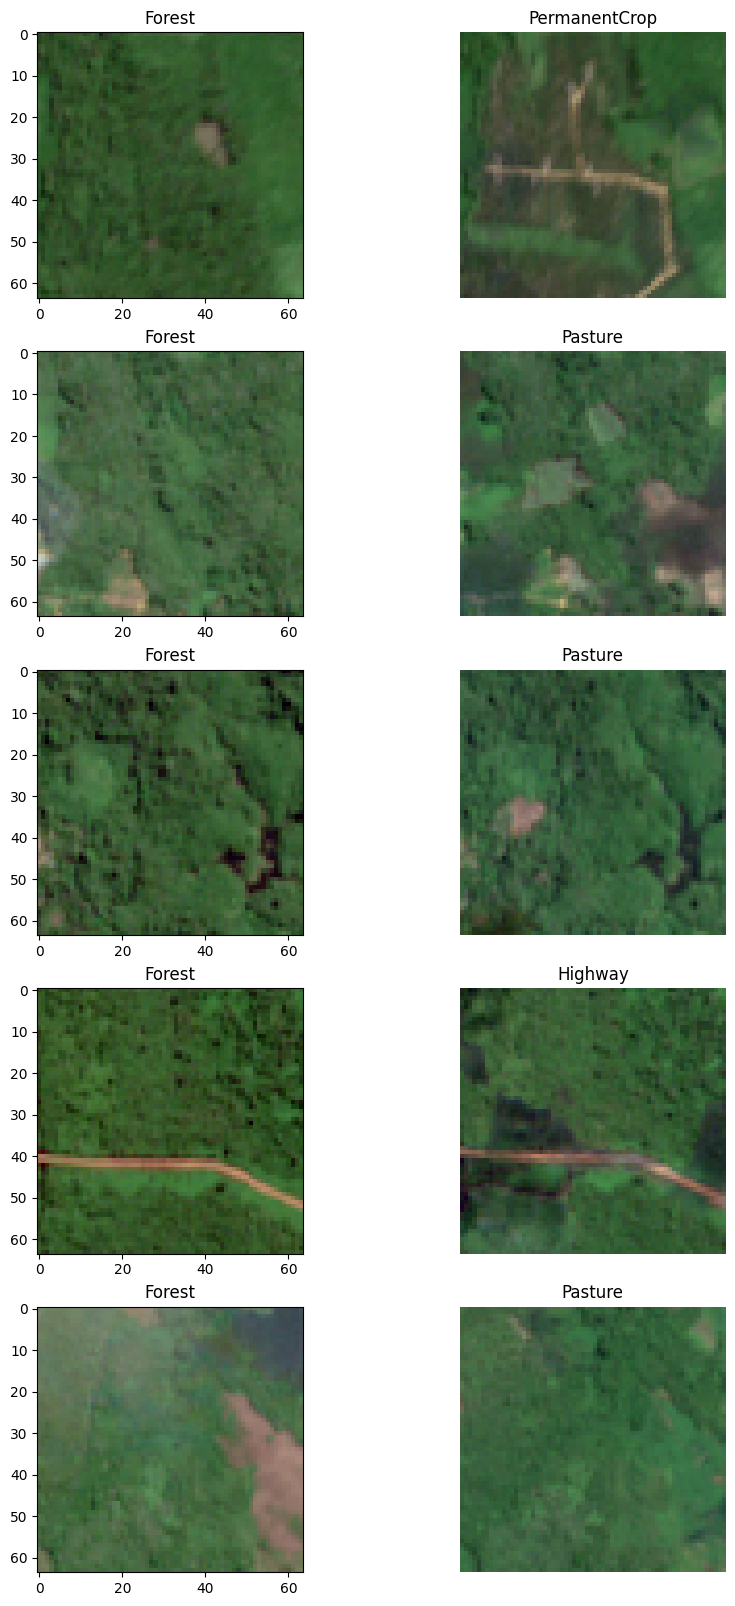

In [ ]:
plt.figure(figsize=(10, 20))
count = 1
for i in range(10,15):
  ax = plt.subplot(5, 2, count)
  count += 1
  plt.title(class_names[deforestation_conf[i,1].astype('int')])
  plt.imshow(tiles[np.where(tile_chooser_2020==1)][np.where(chooser_2020==1)][np.where(deforestation_map==1)][np.where(deforestation[:,2] > 0.95)][i])

  ax = plt.subplot(5, 2, count)
  count += 1
  plt.title(class_names[deforestation_conf[i,0].astype('int')])
  plt.imshow(tiles2023[np.where(tile_chooser_2023==1)][np.where(chooser_2023==1)][np.where(deforestation_map==1)][np.where(deforestation[:,2] > 0.95)][i])
  plt.axis("off")